# Rössler system: homoclinic orbit

Math 747/847 Nonlinear dynamics, University of New Hampshire, spring 2021, J. Gibson

This notebook illustrates the calculation of a homoclinic orbit of the Rössler system. The steps of the calculation are

1. write code for time-integration of the Rössler system
2. define a Poincare section in the x=0 plane
3. write code for computing the points where trajectories intersect the Poincare section
4. write code for calcuating a map from the Poincare intersection to itself, $F: (y_n, z_n) \rightarrow (y_{n+1}, z_{n+1})$
5. estimate a fixed point of $F$ using $y_{n}, y_{n+1}$ and  $z_{n}, z_{n+1}$ recurrence plots
6. find the fixed point by solving $F(y,z) = (y,z)$ with a nonlinear solver and the estimate for an initial guess 
7. linearize $F$ dynamics about the fixed point and compute the stable and unstable eigenvectors
8.  forward-iterate small perturbations along unstable eigenvector to approximate the unstable manifold
9. **don't** backward-iterate small perturbations along unstable eigenvector to approximate the unstable manifold!
10. instead, to find the homoclinic intersection, search along the unstable manifold for a point that forward-maps somewhere near the fixed point
11. then, near that point, do a local polynomial approximation of the unstable manifold as $z$ as a function of $y$
12.  search over the $y$-parameterized local approximation of the unstable manifold for a point $(y, z(y))$ for a point that approaches the fixed point under iteration of the forward map
13. then find the homoclinic orbit by finding a small unstable perturbation of the fixed point that maps into the homoclinic point
14. show that the fixed point of the map corresponds to a periodic orbit of the flow
15. show the homoclinic trajectory of the map as a homoclinic orbit of the flow



##  1. Rössler system integration code

In [1]:
using Plots, LinearAlgebra
gr()

function rk4(f, y₀, Δt, N, t₀=0.0) 
   
    # fix up Δt so it evenly divides time interval
    #Δt = (t₁ - t₀)/N
    Δt2 = Δt/2
    Δt6 = Δt/6
    t₁ = t₀ + (N-1)*Δt
    
    t = range(t₀, t₁, length=N)

    y = zeros(N, length(y₀))
    y[1,:] .= y₀

    for n = 1:N-1
        yn = y[n,:]
        s1 = f(yn)
        s2 = f(yn + Δt2*s1)
        s3 = f(yn + Δt2*s2)
        s4 = f(yn + Δt *s3)
        y[n+1, :] .=  yn + Δt6*(s1 + 2s2 + 2s3 + s4) # RK4 update formula
    end
    t,y
end

function rk4!(f, x, Δt, N) 
   
    # fix up Δt so it evenly divides time interval
    #Δt = (t₁ - t₀)/N
    Δt2 = Δt/2
    Δt6 = Δt/6

    for n = 1:N    
        s1 = f(x)
        s2 = f(x + Δt2*s1)
        s3 = f(x + Δt2*s2)
        s4 = f(x + Δt *s3)
        x .=  x + Δt6*(s1 + 2s2 + 2s3 + s4) 
    end
    x
end

function rossler_f(a,b,c)
    function f(x)
        [-x[2]-x[3]; x[1] + a*x[2]; b + x[3]*(x[1]-c)]
    end
    return f
end

function rossler_eqbs(a,b,c)
    z0 = (c - sqrt(c^2-4a*b))/(2a)
    z1 = (c + sqrt(c^2-4a*b))/(2a)
    return ([a*z0; -z0; z0], [a*z1; -z1; z1])
end

function fnX!(X, f, n)
    fX = copy(X)
    for k=1:n
        fX = mapslices(f,fX,dims=2)
    end
    #fX = trim(fX)
    fX
end

function Df(f,x)
    fx = f(x)
    m = length(fx)
    n = length(x)
    df = zeros(m,n)
    eps = 1e-07
    for j in 1:n
        x_eps = copy(x)
        x_eps[j] = x_eps[j] + eps
        fx_eps = f(x_eps)
        dfdx = (fx_eps-fx)/eps
        for i in 1:m
            df[i,j] = dfdx[i]
        end
    end
    df
end


function plotfnX!(X, f, n; label="", color=:black, linestyle=:solid, width=1)
    fX = copy(X)
    for k=1:n
        fX = mapslices(f,fX,dims=2)
    end
    #fX = trim(fX)
    plot!(fX[:,1], fX[:,2], label=label, color=color, linestyle=linestyle, linewidth=width)
end

function eigensort(A)
    Lambda, V = eigen(A)
    s,u = abs(Lambda[1]) < 1 ? (1,2) : (2,1) 
    return Lambda[s], Lambda[u], V[:,s], V[:,u]
end

function linesegment(P,Q, N=100)
    PQ = zeros(N,length(P))
    c = range(0, 1, length=N)
    for n=1:N
        PQ[n,:] = c[n]*P + (1-c[n])*Q
    end
    PQ
end

linesegment (generic function with 2 methods)

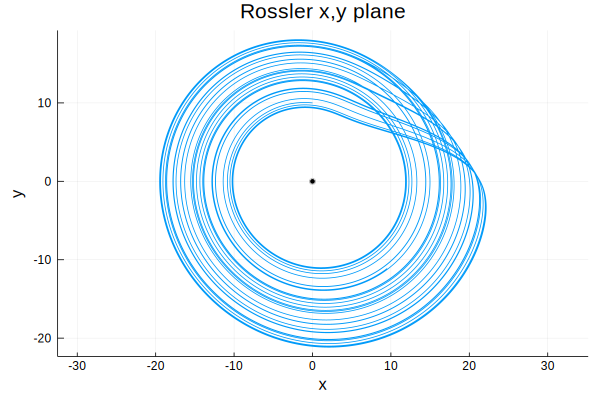

In [6]:
a,b,c = 0.1, 0.1, 14

x₀ = [0.0; 10.0; 0.01]
N = 20001
Δt = 0.01
t₀ = 0.0

(xstar0, xstar1) = rossler_eqbs(a,b,c)

f  = rossler_f(a,b,c)

t,x = rk4(f, x₀, Δt, N)

plot(x[:,1], x[:,2], label="")
scatter!([xstar0[1]], [xstar0[2]], markercolor=:black, label="")
plot!(xlabel="x",ylabel="y",aspect_ratio=:equal)
plot!(title="Rossler x,y plane")

## 2. Define a Poincare section, the x=0 plane

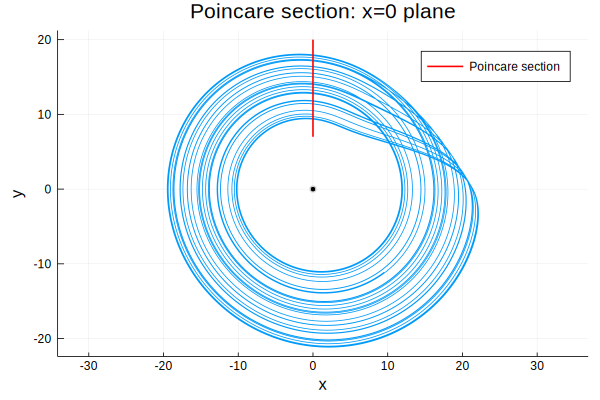

In [7]:
plot(x[:,1], x[:,2], label="")
scatter!([xstar0[1]], [xstar0[2]], markercolor=:black, label="")
plot!([0.0; 0.0], [7.0; 20.0], color=:red, width=2, label="Poincare section")
plot!(xlabel="x",ylabel="y",aspect_ratio=:equal)
plot!(title="Poincare section: x=0 plane")

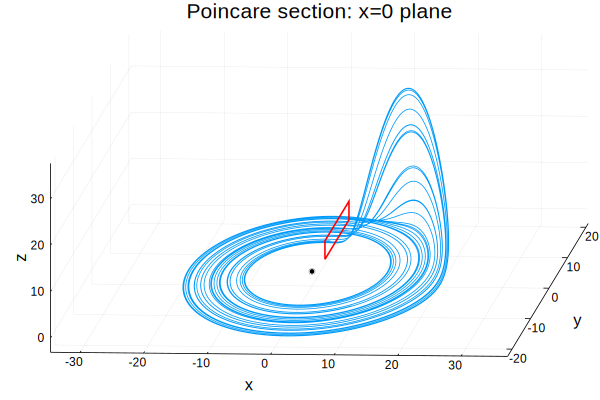

In [8]:
plot(x[:,1], x[:,2], x[:,3], label="")
scatter!([xstar0[1]], [xstar0[2]], [xstar0[3]], markercolor=:black, label="")
xpoinc = [0.0;  0.0;  0.0; 0.0; 0.0]
ypoinc = [7.0; 20.0; 20.0; 7.0; 7.0]
zpoinc = [-2.0;  -2.0;  2.0; 2.0; -2.0]
plot!(xpoinc, ypoinc, zpoinc, color=:red, width=2, label="")
plot!(xlabel="x",ylabel="y",zlabel="z")
plot!(camera=(10,50), aspect_ratio=:equal, legend=:topleft)
plot!(title="Poincare section: x=0 plane")

## 3,4. Write code to calculate Poincare intersections and Poincare map 

In [9]:
using Polynomials

function rk4step(f, x, Δt)     
    s1 = f(x)
    s2 = f(x + Δt/2*s1)
    s3 = f(x + Δt/2*s2)
    s4 = f(x + Δt *s3)
    x + Δt/6*(s1 + 2s2 + 2s3 + s4) 
end

# From a point (x,y,z), integrate dx/dt = f(x) until it passes through the Poincare section (e.g. x=0)
# going in the positive/negative direction according to s = +/-1 

function rk4map(f, x; Δt=0.01, s=-1) 
   
    m = length(x)
    
    # initiate with five successive rk4steps (in order to do 4th-order interp later)
    # X[i,n] is ith coordinate of nth runge-kutta step
    X = zeros(m, 5)
    X[:,1] = copy(x)
    for n=1:4
        X[:,n+1] = rk4step(f, X[:,n], Δt)
    end

    p = 1
    # integrate until x crosses x[p]=0 plane, s= ±1, x[p] increasing/decreasing,
    # determined by x[2] and x[4] spanning the x[p]=0 plane
    count = 0
    while !(s*X[p,2] < 0.0 && s*X[p,4] > 0.0)
        X[:,1:4] .= X[:, 2:5]  # shift in time
        X[:,5] .= rk4step(f, X[:,4], Δt)
        count = count + 1
    end
    #@show count
    xnext = zeros(m)
    
     # Do polynomial interpolation to find x[2:end] values of x[1]=0 crossing
    for i=1:m
        polyfit = fit(X[p,:], X[i,:])
        xnext[i]= polyfit(0.0)
    end
    xnext[p] = 0.0
    xnext
end

rk4map (generic function with 1 method)

Ok, now we use that code to calculate 100 Poincare intersections.

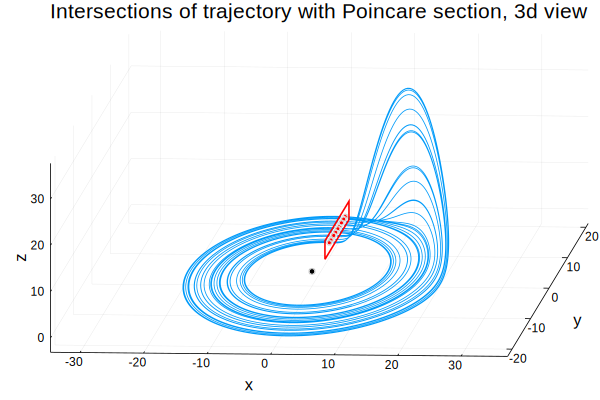

In [13]:
x₀ = [0.0; 13.0; 0.005]

x₀ .= rk4map(f,x₀)

N = 100
X = zeros(N,3)
X[1,:] .= x₀
for n=1:N-1
    X[n+1,:] .= rk4map(f, X[n,:])
end

plot(x[:,1], x[:,2], x[:,3], label="")
scatter!([xstar0[1]], [xstar0[2]], [xstar0[3]], markercolor=:black, label="")
scatter!(X[:,1], X[:,2], X[:,3], markersize=3, label="", color=:red)
plot!(xpoinc, ypoinc, zpoinc, color=:red, width=2, label="")
plot!(xlabel="x", ylabel="y", zlabel="z")
plot!(camera=(10,50), aspect_ratio=:equal)
plot!(title="Intersections of trajectory with Poincare section, 3d view")
#scatter(X[1:N-k,2], X[k+1:N,2])
#y = 12:22
#plot!(y,y,legend=:topleft)

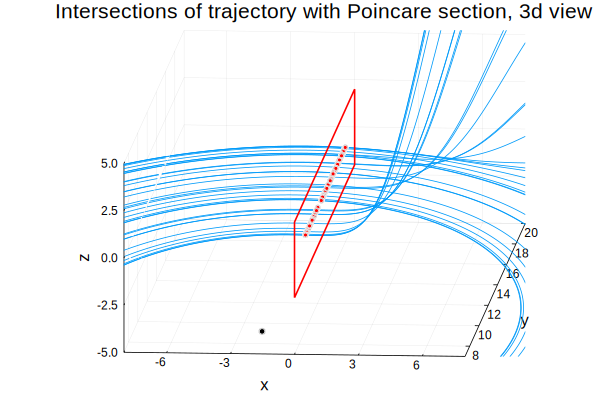

In [14]:
plot!(xlim=(-8,8),ylim=(7,20),zlim=(-5,5))

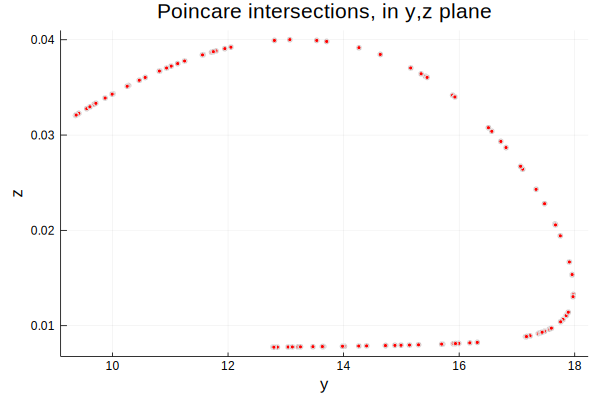

In [15]:
scatter(X[:,2], X[:,3], markersize=3, label="", color=:red)
plot!(xlabel="y", ylabel="z")
plot!(title="Poincare intersections, in y,z plane")

Wonderful! That was a hundred Poincare intersections. Now let's generate a thousand.

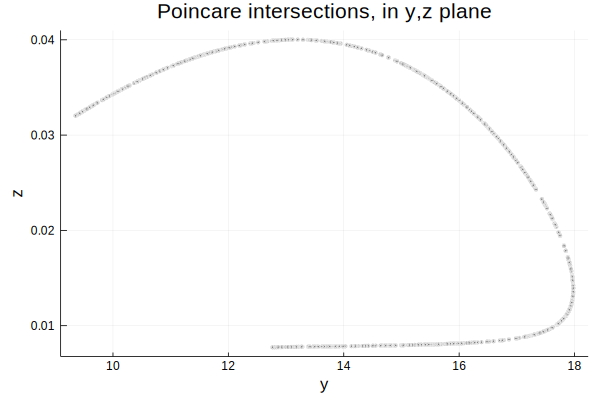

In [16]:
x₁= rk4map(f,x₀)

N = 1000
X = zeros(N,3)
X[1,:] .= x₁
for n=1:N-1
    X[n+1,:] .= rk4map(f, X[n,:])
end

X
k = 1
scatter(X[:,2], X[:,3], markersize=2, label="", color=:grey)
plot!(xlabel="y", ylabel="z")
plot!(title="Poincare intersections, in y,z plane")
#scatter(X[1:N-k,2], X[k+1:N,2])
#y = 12:22
#plot!(y,y,legend=:topleft)



## 5. Estimate a fixed point of the Poincare map using recurrence plots

Plot $y_{n+1}$ versus $y_n$, just like we did with the logistic map.

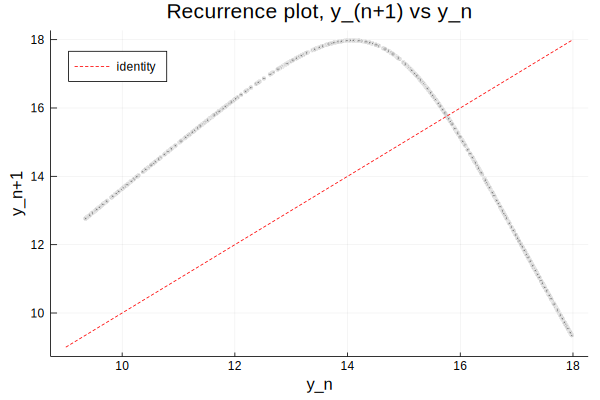

In [17]:
N = size(X,1)
k = 1
scatter(X[1:N-k,2], X[1+k:N,2], markersize=2, label="", color=:grey)
plot!([9, 18], [9, 18], color=:red, linestyle=:dash, label="identity")
plot!(xlabel="y_n", ylabel="y_n+$k", legend=:topleft)
plot!(title="Recurrence plot, y_(n+1) vs y_n")

Amazing! It looks like $y_{n+1}$ is a function of $y_n$ alone, and that two $y_n$ values can map into the same $y_{n+1}$. But this can' be true, because the ODE is reversible in time. So there must be some thickness to the apparent line. But still, we should be able to find a fixed point near where it appears that $(y_{n+1}, z_{n+1}) = (y_n, z_n)$.

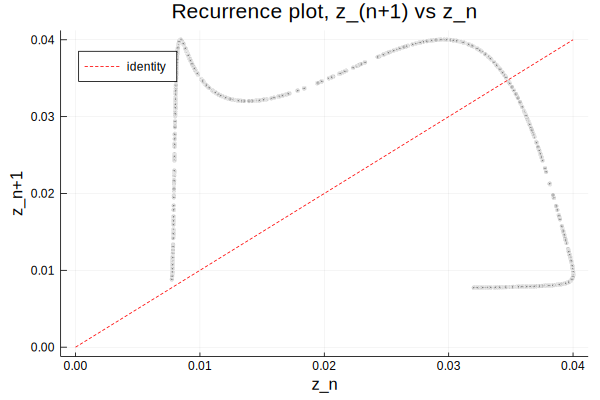

In [18]:
N = size(X,1)
k = 1
scatter(X[1:N-k,3], X[1+k:N,3], markersize=2, label="", color=:grey)
plot!([0, 0.04], [0, 0.04], color=:red, linestyle=:dash, label="identity")
plot!(xlabel="z_n", ylabel="z_n+$k", legend=:topleft)
plot!(title="Recurrence plot, z_(n+1) vs z_n")

Guess that there's a fixed point of Poincare map at (y,z) given by intersections with identity at $y \approx 16$ and $z \approx 0.035$, and of course $x=0$. 

In [19]:
xguess3d = [0; 16; 0.035]

3-element Array{Float64,1}:
  0.0
 16.0
  0.035

In [20]:
rk4map(f, xguess3d)

3-element Array{Float64,1}:
  0.0
 15.143467911126143
  0.03709290017147794

Hooray! The guess nearly maps into itself under rk4 integration.

## 6. Find the fixed point using a nonlinear solver

To use the nonlinear solver we have to re-express the map on the Poincare section as a function of two variables, $F: (y_n, z_n) \rightarrow (y_{n+1}, z_{n+1})$. 

In [21]:
function F(x)
    xyz = rk4map(f, [0.0; x[1]; x[2]])
    return [xyz[2]; xyz[3]]
end
xguess = [16; 0.035]
F(xguess)

2-element Array{Float64,1}:
 15.143467911126143
  0.03709290017147794

Import Julia's standard nonlinear solver and compute the fixed point.

In [22]:
using NLsolve

solution = fixedpoint(F, xguess)

Results of Nonlinear Solver Algorithm
 * Algorithm: Anderson m=2 beta=1 aa_start=1 droptol=0
 * Starting Point: [16.0, 0.035]
 * Zero: [15.762887293033883, 0.034748737211586236]
 * Inf-norm of residuals: 0.000000
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 7
 * Jacobian Calls (df/dx): 0

In [23]:
xstar = solution.zero
xnext = F(xstar)

@show xstar 
@show xnext
@show norm(xstar-xnext)

xstar = [15.762887293033883, 0.034748737211586236]
xnext = [15.762887296680114, 0.034748737249837194]
norm(xstar - xnext) = 3.6464323921434825e-9


3.6464323921434825e-9

Hooray! We've got a fixed point of the Poincare map accurate to nine digits. That's good enough, considering our time-stepping is 4th-order with $\Delta t \approx 10^{-2}$.

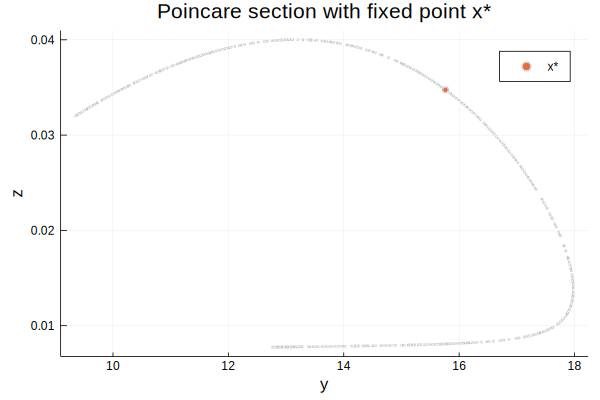

In [24]:
scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], label="x*")
plot!(xlabel="y", ylabel="z")
plot!(title="Poincare section with fixed point x*")

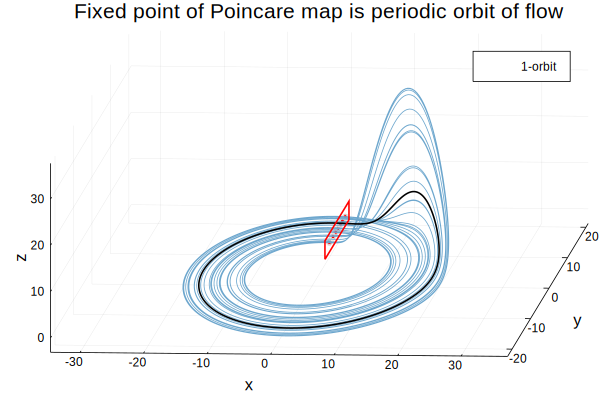

In [26]:
x₀ = [0.0; xstar[1]; xstar[2]]
Norb = Int64(round(6.4/Δt))

t,xorb = rk4(f, x₀, Δt, Norb)

scatter(X[:,1], X[:,2], X[:,3], markersize=3, label="", color=:red)
plot!(x[:,1], x[:,2], x[:,3], label="", color=:skyblue3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:black, width=2, label="1-orbit")
plot!(xpoinc, ypoinc, zpoinc, color=:red, width=2, label="")
plot!(xlabel="x", ylabel="y", zlabel="z")
plot!(camera=(10,50), aspect_ratio=:equal)

plot!(title="Fixed point of Poincare map is periodic orbit of flow")

## Linearize the Poincare map about the fixed point

In [27]:
DF = Df(F, xstar)

2×2 Array{Float64,2}:
 -2.51052     0.00621657
  0.0111574  -2.76285e-5

In [28]:
eigensort(DF)

(-3.5741369148426395e-10, -2.510551683407936, [-0.002476198087554611, -0.9999969342168161], [-0.999990124403627, 0.004444220428645136])

(lambdas, lambdau) = (-3.5741369148426395e-10, -2.510551683407936)


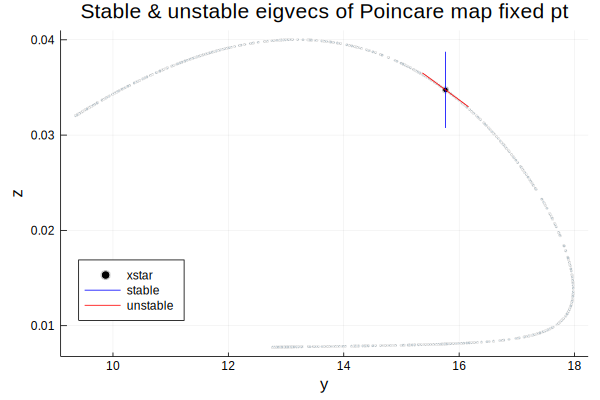

In [29]:
lambdas, lambdau, vs, vu = eigensort(DF)
@show lambdas, lambdau

r=0.4
Svec = linesegment(xstar + r/100*vs, xstar - r/100*vs, 2)
Uvec = linesegment(xstar + r*vu, xstar - r*vu, 2)

w0 = 1  # linewidths for fp0 and fp1 unstable manifolds
w1 = 2

scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], markershape=:circ, label="xstar", color=:black)

plotfnX!(Svec, F, 0, label="stable", color=:blue, width=w0)
plotfnX!(Uvec, F, 0, label="unstable", color=:red, width=w0)

plot!(xlabel="y", ylabel="z", title="")
plot!(legend=:bottomleft)

plot!(title="Stable & unstable eigvecs of Poincare map fixed pt")

## 8. Estimate unstable manifold through forward iterations of unstable eigvec

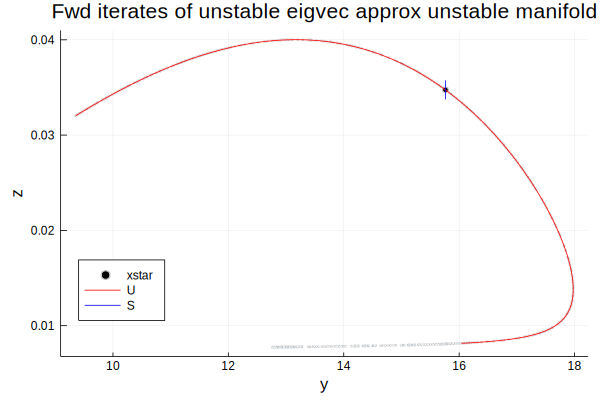

In [30]:
r=0.001
Svec = linesegment(xstar + r*vs, xstar - r*vs, 100)
Uvec = linesegment(xstar + r*vu, xstar - r*vu, 100)

w0 = 1  # linewidths for fp0 and fp1 unstable manifolds
w1 = 0

scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], markershape=:circ, label="xstar", color=:black)

n = 10
ninv = 0
plotfnX!(Uvec, F, n, label="U", color=:red, width=w0)
plotfnX!(Svec, F, ninv, label="S", color=:blue, width=w0)


plot!(xlabel="y", ylabel="z", title="")
plot!(legend=:bottomleft)
plot!(title="Fwd iterates of unstable eigvec approx unstable manifold")

## 9. Don't try to estimate stable manifold via inverse map!

However, don't try to integrate stable eigvec backwards in time to approximate stabe manifold! The Rossler system is very strongly damped forwards in time, and is thus hugely unstable in backwards time! When I do try compute the inverse Poincare map, the time integration goes on forever and I have to interrupt execution, probably because the trajectory never returns to the Poincare section.

In [26]:
function Finv(x)
    xyz = rk4map(f, [0.0; x[1]; x[2]], Δt=-0.01, s=1)
    return [xyz[2]; xyz[3]]
end
#xguess = [15.8; 0.035]
#poincmapinv(xstar)

LoadError: InterruptException:

## 10. Instead, guess that homoclinic intersection occurs straight down in z from fixed point

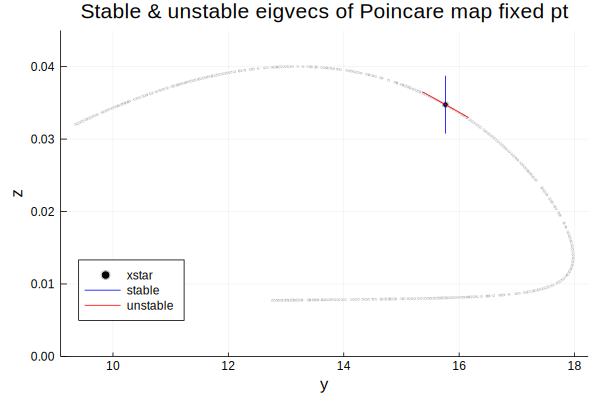

In [31]:
r=0.4
Svec = linesegment(xstar + r/100*vs, xstar - r/100*vs, 2)
Uvec = linesegment(xstar + r*vu, xstar - r*vu, 2)

scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], markershape=:circ, label="xstar", color=:black)

plotfnX!(Svec, F, 0, label="stable", color=:blue, width=w0)
plotfnX!(Uvec, F, 0, label="unstable", color=:red, width=w0)

plot!(xlabel="y", ylabel="z", title="")
plot!(legend=:bottomleft)
plot!(ylim=(0.0, 0.045))

plot!(title="Stable & unstable eigvecs of Poincare map fixed pt")

Instead of backwards-integrating the stable manifold, take a guess from the strong $dz/dt \approx -c z + z_0$ damping that the stable manifold of the fixed point is nearly vertical, so that the homoclinic intesection is almost directly underneath the fixed point. 

In [32]:
xhomoguess = [15.76; 0.008]

@show xstar;
@show F(xhomoguess);

xstar = [15.762887293033883, 0.034748737211586236]
F(xhomoguess) = [15.769965617294423, 0.03471722291359138]


In [33]:
norm(F(xhomoguess)-xstar)

0.007078394414577988

Yes! That guess maps pretty close to the fixed point! Let's get a better guess by interpolating points on the unstable manifold.

## 11. Local polynomial interpolation of unstable manifold, near homoclinic guess

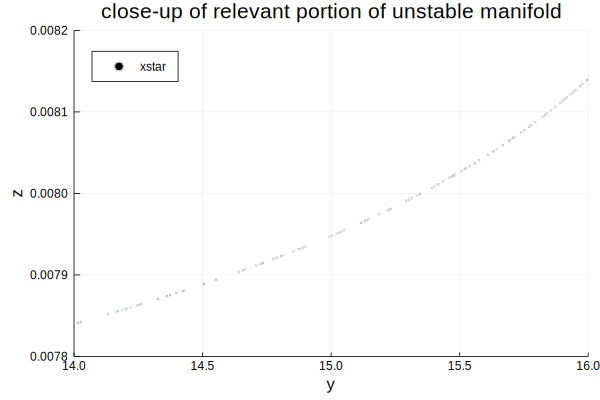

In [34]:
scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], markershape=:circ, label="xstar", color=:black)

plot!(xlabel="y", ylabel="z", title="")
plot!(legend=:topleft)
plot!(xlim=(14,16),ylim=(0.0078,0.0082))
plot!(title="close-up of relevant portion of unstable manifold")

Select the points on the Poincare section that are near the guess for the homocliic point.

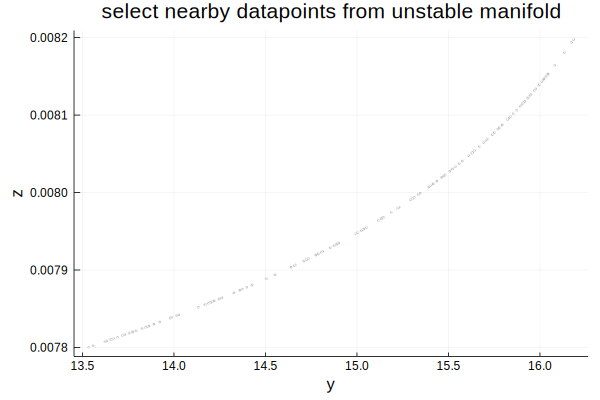

In [35]:
i = findall(z -> 0.0078 < z <0.0082, X[:,3])

scatter(X[i,2], X[i,3], markersize=1, label="")
plot!(xlabel="y", ylabel="z", title="")
plot!(title="select nearby datapoints from unstable manifold")

Make a polynomial model of the unstabe manifold near the guess as a function of y

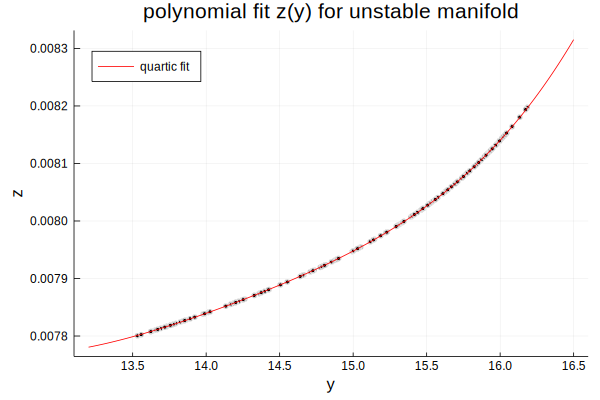

In [36]:
# fit a 4th order polynomial for z = X[i,3] as a function of y = X[i,2]
z = fit(X[i,2], X[i,3], 4)

y = 13.2:0.02:16.5
scatter(X[i,2], X[i,3], markersize=3, label="", markercolor=:black)
plot!(y, z.(y), width=1, color=:red, label="quartic fit")
plot!(xlabel="y", ylabel="z", title="")
plot!(legend=:topleft)
plot!(title="polynomial fit z(y) for unstable manifold")

In [38]:
xhomoguess

2-element Array{Float64,1}:
 15.76
  0.008

## Search for homoclinic point along parameterized approximation of unstable manifold

We don't need the homoclinic point to any great accuracy. We care more about getting the homoclinic trajectory. So we approximate the homoclinic point crudely, and then use that to get a crude homoclinic trajectory, starting from a perturbation of the fixed point. Then we will refine the homoclinic trajectory to greater accuracy.

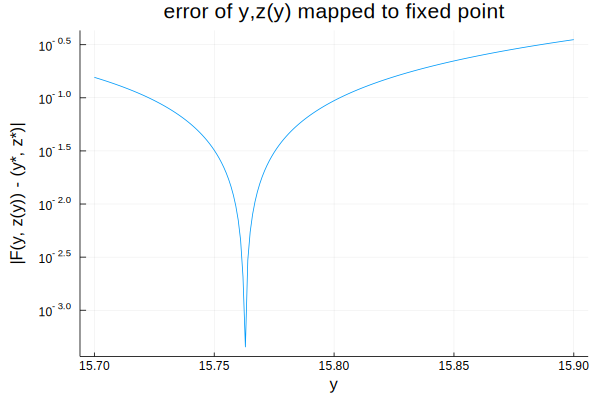

In [39]:
dist = y -> norm(F([y, z(y)]) - xstar)

y = 15.7:0.001:15.9
plot(y, dist.(y), yaxis=:log, label="")
plot!(xlabel="y", ylabel="|F(y, z(y)) - (y*, z*)|")
plot!(title="error of y,z(y) mapped to fixed point")

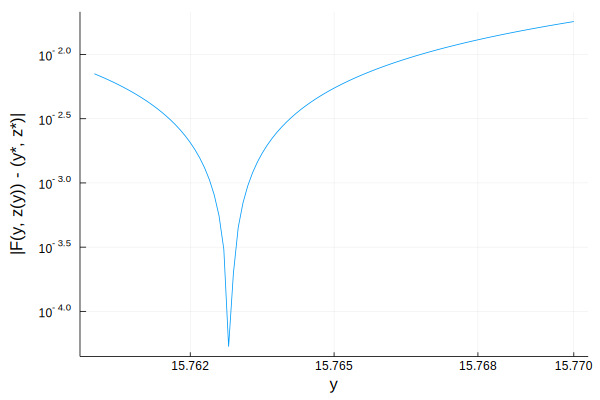

In [40]:
y = 15.76:0.0001:15.77
plot(y, dist.(y), yaxis=:log, label="")
plot!(xlabel="y", ylabel="|F(y, z(y)) - (y*, z*)|", title="")

Ok, just march over a fine grid and choose the smallest error. Close enough for our purposes.

In [41]:
y = 15.76:0.00001:15.77
(mindist,i) = findmin(dist.(y))

@show mindist
y[i]

mindist = 2.915428639842485e-6


15.76282

In [42]:
xhomo = [y[i], z(y[i])]
@show xhomo
@show F(xhomo) - xstar
@show F(F(xhomo)) - xstar

xhomo = [15.76282, 0.008080300936161522]
F(xhomo) - xstar = [2.9154003069464807e-6, -1.2853181324823382e-8]
F(F(xhomo)) - xstar = [-7.315617725822676e-6, 3.2566931720823256e-8]


2-element Array{Float64,1}:
 -7.315617725822676e-6
  3.2566931720823256e-8

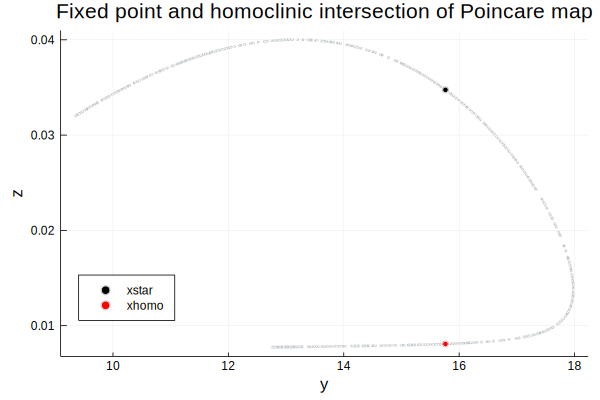

In [43]:
scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], markershape=:circ, label="xstar", color=:black)
scatter!([xhomo[1]], [xhomo[2]], markershape=:circ, label="xhomo", color=:red)
plot!(xlabel="y", ylabel="z", title="")
plot!(legend=:bottomleft)
plot!(title="Fixed point and homoclinic intersection of Poincare map")

## 13. Find a crude homoclinic orbit by hitting the homoclinic point from small unstable perturbation from fixed point.

Now try to construct homoclinic orbit --an orbit that diverges from the fixed point along its unstable manifold, bounces around the attractor, and then approaches the fixed point along its stable manifold. We approximate the starting point with be a small perturbation of the fixed pt along the unstable eigenvector. Here I started with a guess for a finite, approximate homoclinic orbit as a small perturbation from the fixed point along the unstable eigenvector: $x = x^* + r v_u$ for $r=10^{-6}$. I plotted 18 or so forward iterations, and adjusted $r$ it until the 18th iterate landed by eye on the homoclinic point, so that the 19th iterate would follow the homoclinic point to the neighborhood of the fixed point. That happens at $r=1.7 \times 10^{-6}$. The plot shows the 18th iterate for $r= 1.6 \times 10^{-6}$ falling just short of the homoclinic point.

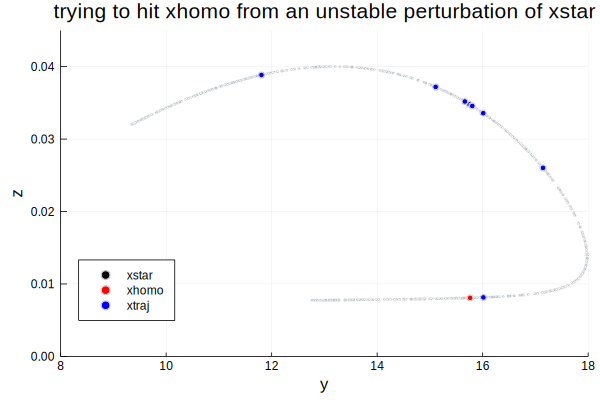

In [44]:
scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], markershape=:circ, label="xstar", color=:black)
scatter!([xhomo[1]], [xhomo[2]], markershape=:circ, label="xhomo", color=:red)

N = 19
Ninv = 0


r₀ = 1.6e-06
x₀ = xstar + r₀*vu

Ntot = N + Ninv
xtraj = zeros(Ntot,2)
xtraj[1,:] .= x₀

for n=1:Ntot-1
    xtraj[n+1,:] .= F(xtraj[n,:])
end
scatter!(xtraj[:,1], xtraj[:,2], markershape=:circ, label="xtraj", color=:blue)
    
plot!(xlabel="y", ylabel="z", title="")
plot!(legend=:bottomleft)
plot!(xlim=(8,18),ylim=(0.0, 0.045))
plot!(title="trying to hit xhomo from an unstable perturbation of xstar")

#mapslices(x -> norm(x-xstar), xtraj, dims=2)


## Refine the homoclinic orbit by optimizing its approach to the fixed point

Now get a few more digits of accuracy by fine-tuning $r$ while looking at $|F^n(x) - x^*|$. If $x$ is on homoclinic trajectory, then $\lim_{n\rightarrow \infty} |F^n(x) - x^*| = 0$. So we adjust $r$ in $x = x^* + r v_u$ until the trajectory approches $x^*$ closely over a number of iterations. I'll show the final result for this: $r = $ 1.697605e-06, which gets within 3e-07 of the fixed point.

In [45]:
#r₀ = 1.697606e-06
r₀ = 1.697606e-06
x₀ = xstar + r₀*vu

Ntot = 28
xtraj = zeros(Ntot,2)
xtraj[1,:] .= x₀

for n=1:Ntot-1
    xtraj[n+1,:] .= F(xtraj[n,:])
end

mapslices(x -> norm(x-xstar), xtraj, dims=2)

28×1 Array{Float64,2}:
 1.6976060002770808e-6
 4.26557074693096e-6
 1.0705294923799273e-5
 2.6879778161563677e-5
 6.747974439624232e-5
 0.00016941281699147558
 0.00042532941285965326
 0.0010677291397016351
 0.002681123708249783
 0.006727696492182186
 0.01691157622499113
 0.042321164216311075
 0.10708262577765007
 ⋮
 4.153506348091525
 0.026668692275682006
 3.6079657043980857e-7
 9.094435279521757e-7
 2.2795588647295444e-6
 5.726591588104508e-6
 1.4373268826535549e-5
 3.608836932844376e-5
 9.059865453806497e-5
 0.0002274522860272803
 0.0005710513435209199
 0.0014335027368019577

Hooray! That's great. We got a homoclinic trajectory accurate to six digits at both ends. Now that we have a good homoclinic trajectory, print out the trajectory and see how it starts and ends near the fixed point, with some bouncing around on the attractor between.

In [46]:
@show xstar
xtraj

xstar = [15.762887293033883, 0.034748737211586236]


28×2 Array{Float64,2}:
 15.7629  0.0347487
 15.7629  0.0347487
 15.7629  0.0347488
 15.7629  0.0347486
 15.7628  0.034749
 15.7631  0.034748
 15.7625  0.0347506
 15.764   0.034744
 15.7602  0.0347606
 15.7696  0.0347188
 15.746   0.0348236
 15.8052  0.0345586
 15.6558  0.0352119
  ⋮       
 11.6094  0.0385056
 15.7628  0.00808013
 15.7629  0.0347487
 15.7629  0.0347487
 15.7629  0.0347487
 15.7629  0.0347487
 15.7629  0.0347488
 15.7629  0.0347486
 15.7628  0.0347491
 15.7631  0.0347477
 15.7623  0.0347513
 15.7643  0.0347424

## 15. Plotting the the homoclinic trajectory

First let's plot a few steps of a typical trajectory, to illustrate how points map into each other on the Poincare section. Select an arbitrary starting point on the attractor, call it $x_0$, and plot it as a blue dot. Then draw a line from $x_0$ to $x_1 = F(x_0)$, another line from $x_1$ to $x_2 = F(x_1)$, etc. The lines show how points on the attractor bounce around under the dynamics. 

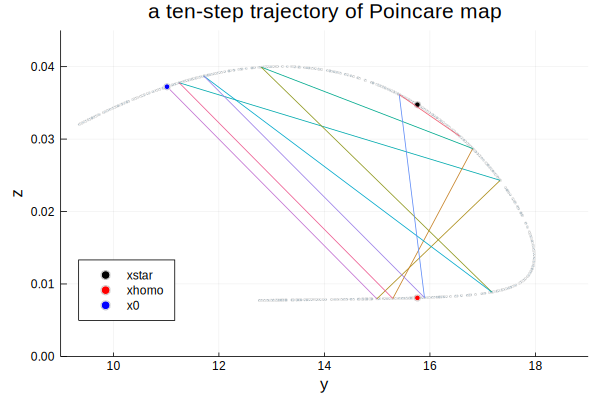

In [47]:
scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], markershape=:circ, label="xstar", color=:black)
scatter!([xhomo[1]], [xhomo[2]], markershape=:circ, label="xhomo", color=:red)
#scatter!(xtraj[:,1], xtraj[:,2], markershape=:circ, label="xtraj", color=:blue)

n₀ = 20
for n=n₀:n₀+10
    plot!(X[n:n+1,2], X[n:n+1,3], label="")
end
scatter!([X[n₀,2]], [X[n₀,3]], markercolor=:blue, label="x0")
plot!(xlabel="y", ylabel="z", title="")
plot!(xlim=(9,19), ylim=(0,0.045))
plot!(legend=:bottomleft)
plot!(title="a ten-step trajectory of Poincare map")

Now we make the same plot for the homoclinic trajectory. Recall that the unstable eigenvalue of the fixed point is $\lambda_u \approx -2.5$. The homoclinic trajectory will begin by bouncing back and forth on opposite sides of the fixed point, with increasing distance, due to the negative sign on $\lambda_u$. When the perturbations grow large enough, the trajectory bounces around the attractor a few times until it hits the homoclinic intersection at $(y,z) \approx (15.76, 0.008)$. From there it approaches the fixed point along its stable manifold.


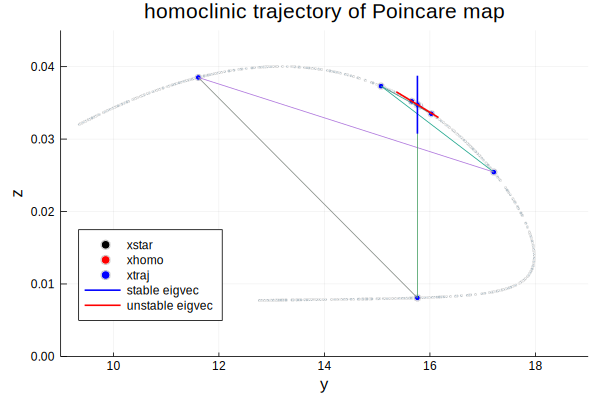

In [48]:


scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], markershape=:circ, label="xstar", color=:black)
scatter!([xhomo[1]], [xhomo[2]], markershape=:circ, label="xhomo", color=:red)
scatter!(xtraj[:,1], xtraj[:,2], markershape=:circ, label="xtraj", color=:blue)

# plot xtraj, the homoclinic trajectory
for n=1:20
    plot!(xtraj[n:n+1,1], xtraj[n:n+1,2], label="") 
end

r=0.4
Svec = linesegment(xstar + r/100*vs, xstar - r/100*vs, 2)
Uvec = linesegment(xstar + r*vu, xstar - r*vu, 2)

plotfnX!(Svec, F, 0, label="stable eigvec", color=:blue, width=2)
plotfnX!(Uvec, F, 0, label="unstable eigvec", color=:red, width=2)

#scatter!(X[n₀,2], X[n₀,3], markercolor=:blue, label=)
plot!(xlabel="y", ylabel="z", title="")
plot!(legend=:bottomleft)
plot!(xlim=(9,19), ylim=(0,0.045))
plot!(legend=:bottomleft)
plot!(title="homoclinic trajectory of Poincare map")



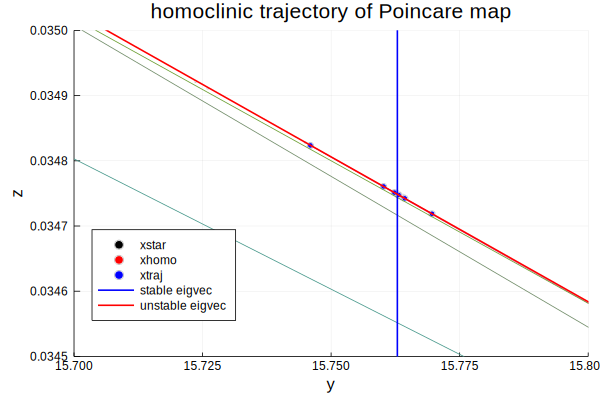

In [49]:
plot!(xlim=(15.7,15.8), ylim=(0.0345,0.035))

The trajectory that is homoclinic to the fixed point of the Poincare map corresponds to homoclinic orbit of the periodic orbit of the flow. Most fo the homoclinic trajectory is plotted in red, but the final approach back to the periodic orbit is in blue.

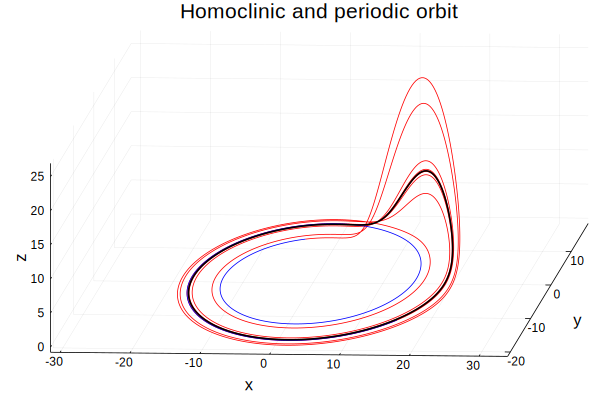

In [51]:
x₀ = [0.0; xstar[1]; xstar[2]]
Norb = Int64(round(6.4/Δt))

t,xorb = rk4(f, x₀, Δt, Norb)

Na = 11000
x₀ = [0.0; xhomo[1]; xhomo[2]]
t, xhomorb_a = rk4(f, x₀, Δt, Na)
plot(xhomorb_a[:,1], xhomorb_a[:,2], xhomorb_a[:,3], color=:red, width=1, label="")

Nb = 1000
x₀ = xhomorb_a[Na,:]
t, xhomorb_b = rk4(f, x₀, Δt, Nb)
plot!(xhomorb_b[:,1], xhomorb_b[:,2], xhomorb_b[:,3], color=:blue, width=1, label="")


plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:black, width=2, label="")

plot!(xlabel="x", ylabel="y", zlabel="z")
plot!(camera=(10,50), aspect_ratio=:equal, legend=:topleft)

plot!(title="Homoclinic and periodic orbit")

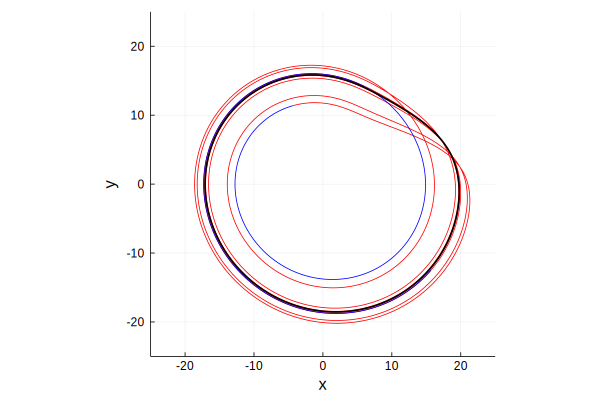

In [52]:
plot(xhomorb_a[:,1], xhomorb_a[:,2], color=:red, width=1, label="")
plot!(xhomorb_b[:,1], xhomorb_b[:,2], color=:blue, width=1, label="")
plot!(xorb[:,1], xorb[:,2], color=:black, width=2, label="")

plot!(xlabel="x", ylabel="y", aspect_ratio=:equal)
plot!(xlim=(-25,25), ylim=(-25,25))

## A trapping region of the Poincare map

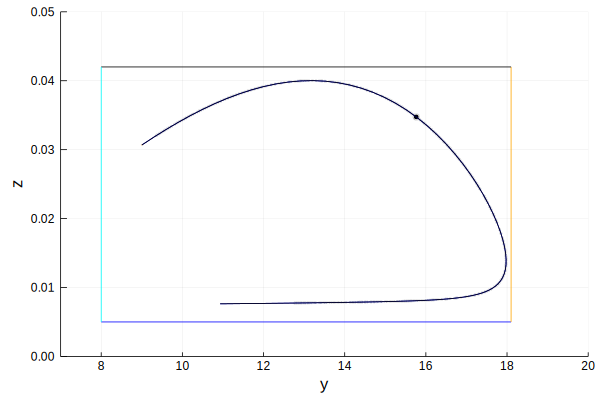

In [53]:
A = [8.0; 0.005]
B = [18.1; 0.005]
C = [18.1; 0.042]
D = [8.0; 0.042]

Ns = 100
AB = linesegment(A,B, Ns)
BC = linesegment(B,C, Ns)
CD = linesegment(C,D, Ns)
DA = linesegment(D,A, Ns)

scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], markershape=:circ, label="xstar", color=:black)

#xguess = [15.76; 0.035]
#poincmap(xguess)

#plotfnX!(Svec, F, 0, label="stable", color=:blue, width=w0)
#plotfnX!(Uvec, F, 0, label="unstable", color=:red, width=w0)

plotfnX!(AB, F, 0, label="", color=:blue, width=w0)
plotfnX!(BC, F, 0, label="", color=:orange, width=w0)
plotfnX!(CD, F, 0, label="", color=:black, width=w0)
plotfnX!(DA, F, 0, label="", color=:cyan, width=w0)
plotfnX!(AB, F, 1, label="", color=:blue, width=w0)
plotfnX!(BC, F, 1, label="", color=:orange, width=w0)
plotfnX!(CD, F, 1, label="", color=:black, width=w0)
plotfnX!(DA, F, 1, label="", color=:cyan, width=w0)

plot!(xlabel="y", ylabel="z", title="")
plot!(xlim=(7,20), ylim=(0.0,0.05), legend=:none)